## Sentiment analysis: Towards vector representation

### Introduction<br>
For any task involving natural language processing, there are several factors that influence the metrics of the system like size of text corpus, vectorization technique, choice of model to name a few. In this notebook we will try to understand one such important step in the NLP lifecyle i.e., vectorization. <br>

**What is vectorization?**<br>
Machine learning models or neural networks do not understand raw text data. It needs to converted to some numeric representation for it to be ingested into a model. Vectorizers serve this exact purpose of converting raw text to numeric vectors.<br>

There are many methods out there that can be used to achieve this. On a high level they can be categorised into two groups<br>

1. Distributional similarity based : Meaning of a word is derived from the context it is used in.<br>
2. Distributional hypothesis based. : Words used in similar context have similar meaning.<br>

To give a brief of each of these categories:<br>
Distributional similarity based vectorizers, derive the representation of a word or a character from a co-occurance matrix of words and thier context. It creates high dimensional sparse vectors to represent a word. These representations are called **distributional representations**.<br>

**Distributional representation techniques**:
1. One Hot encoding
2. Bag of words
3. Bag of N-grams
4. TF-IDF (Term frequency inverse document frequency)

Distributed Hypothesis derives representation of word by training a neural network to generate low dimensional, dense representations of words, such that words used in similar context have similar representations. These representations are called **distributed representations**

**Distributioned representation techniques**:
1. Word2Vec<br>
<t>a. CBoW<br>
<t>b. Skip-gram<br>
2. Glove<br>
3. fasttext<br>

In this notebook we will look deep into distributional similarity and how much do these vectorization techniques impact the performance of the model.

In [21]:
# importing necessary packages
import re
import numpy as np
import pandas as pd
from collections import Counter
import warnings

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from bs4 import BeautifulSoup

from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

stopwords = nltk.corpus.stopwords.words("english")
warnings.filterwarnings("ignore")

### Loading Data

We will used the famous **IMDB_dataset.csv** which has 50000 movie reviews and thier corresponding sentiment. We will use the first 10000 reviews for the sake of simplicity.

You can follow along this notebook by downloading data from the below link<br>
*https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?select=IMDB+Dataset.csv*

In [22]:
csv_file = "data\IMDB_dataset.csv"
df = pd.read_csv(csv_file)
df = df.iloc[:10000, :]
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     10000 non-null  object
 1   sentiment  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [24]:
### utilities
def remove_special_characters(text):
    """Function to parse raw review data and extract
        text from it.
    """
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    text = re.sub('\[[^]]*\]', '', text)
    text = re.sub('[^a-zA-z0-9\s+\,]','',text)
    text = re.sub('\.{2,}','',text)
    return text

def remove_stopwords(text):
    """Function to remove stopwords"""
    text = text.lower()
    words = text.split(" ")
    filtered_words = [i for i in words if i not in stopwords]
    filtered_words = ' '.join(filtered_words)
    return filtered_words

class BuildVocab:
    """Class to build vocabulary for a given series of reviews and vocab size"""
    def __init__(self, sentences: pd.Series, vocab_size:int, unk_token=False):
        self.sentences = sentences
        self.vocab_size = vocab_size
        self.oov_token = unk_token
    
    def __process_sentences(self, sentence:str):
        sentence = re.sub(r'[^a-zA-Z\s+]', '', sentence).strip()
        return sentence
    
    def __sentence2words(self, sentence: str):
        word_list = list()
        for word in sentence.split(" "):
            if len(word) >= 1:
                word_list.append(word)
            else:
                pass
        return list(word_list)
    
    def __get_word_dictionary(self, sentences:list):
        words = list()
        for sentence in sentences:
            word_list = self.__sentence2words(sentence=sentence)
            words.extend(word_list)
        return list(words)
    
    def __get_topn_words(self, word_dictionary:dict):
        sorted_items = sorted(word_dictionary.items(), key=lambda item: item[1], reverse=True)
        top_n_words = [word for word, _ in sorted_items[:self.vocab_size]]
        return top_n_words


    def build(self):
        sentences = self.sentences.apply(self.__process_sentences)
        words = self.__get_word_dictionary(sentences=sentences.values)
        word_count_dict = Counter(words)
        vocab = self.__get_topn_words(word_dictionary=word_count_dict)
        
        if self.oov_token:
            vocab.append("UNK")
        else:
            pass

        index_dict = {x: index for x, index in zip(vocab, range(len(vocab)))}

        return vocab, index_dict

Number of reviews : 10000


<Axes: xlabel='sentiment', ylabel='count'>

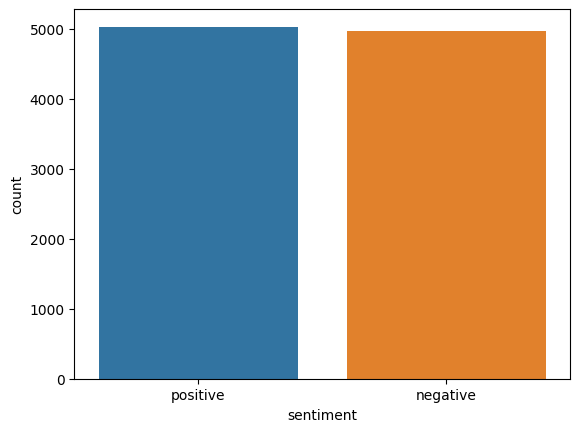

In [25]:
print(f"Number of reviews : {len(df['review'].values)}")
sns.countplot(data=df, x="sentiment")

In [26]:
## viewing a sample review before applying data transformation
df['review'].values[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

### Cleaning and preprocessing

In [27]:
## Cleaning and removing stopwords from reviews
df['review'] = df['review'].apply(remove_special_characters)
df['review'] = df['review'].apply(remove_stopwords)

In [28]:
## Building vocabulary with desired vocab size
vocab, vocab_dict = BuildVocab(sentences=df['review'], vocab_size=1000, unk_token=True).build()

In [29]:
## Spliting the data into train and test sets
train_x, test_x, train_y, test_y = train_test_split(df['review'].values, df['sentiment'].values, test_size=0.2, random_state=22)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape )

(8000,) (8000,) (2000,) (2000,)


## Vectorization

### *One hot encoding*<br>
With a vocabulary size of N words, **each word** is represented by a N-dimensional vector With all zeros except indices where the words are present.<br>

*Limitations*
1. *No semantic meaning,* i.e., low cosine similarity between related words like (apple, mango), (boy, girl), (laptop, developer).
2. *Sparse representation* can cause computational inefficiency with a large vocabulary.
3. *OOV,* i.e., cannot create representations for words that are not present in vocabulary.
4. *Fixed length vector representation,* not all sentences in a passage of text have same number of words.

<br>
<br>

### *Bag of words*<br>
Based on frequency of unique word (vocabulary) present in a text corpus. **Each sentence** is represented by a vector of length same as size of vocabulary. Each index is frequency count of word present in the sentence.<br>

*How is it better than one hot encoding:*<br>

1. *Fixed length vector representation,* now every sentence irrespective of number of words will have same size.<br>

*Limitations*<br>
1. *Sparsity,* larger vocabulary can create high dimensional vectors.<br>
2. *No semantic meaning* does not store any information about the context.<br> 
3. Susceptible to slight variation, small changes can make the representations change drastically.<br>
<br>
<t>Example: ***he** ran Vs **they** ran*</t><br>
<br>
4. *OOV,* i.e., cannot create representations for words that are not present in vocabulary.<br>

In [30]:
bow = CountVectorizer(max_features=150)
bow = bow.fit(train_x)

### Bag of N-grams
Instead of counting frequency of individual tokens, we **count the frequency of group of N-tokens.** Each group is called a N-gram.<br>

*How is it better than BoW:*<br>
1. *Improved semantic understanding,* sentences with same group of words will have similar representation.<br>

*Limitations:*
1. *Sparsity* as the vocabulary increases.<br>
2. *OOV,* i.e., cannot create representations for words that are not present in vocabulary.<br>
3. *High dimensionality,* due to large vocabulary.<br>

In [31]:
N=3
bng = CountVectorizer(ngram_range=(N, N))
bng = bng.fit(train_x)

### TF-IDF: Term Frequency Inverse Document Frequency
Assigns a single float value to a word relative to other words in the sentence and corpus. Frequently occuring words will have lower value and rare words will have higher value hence higher importance.

$$
TF(x) = (Frequency(x)_{sentence} / Count(tokens)_{sentence}
$$

$$
IDF(x) = log(Count(sentences)/ Count(sentences)_{x}
$$

$$
TF_IDF(x) = TF(x)*IDF(x)
$$

*How is it better than BoN:*

1. *Improves semantic understanding,* by assigning weightage to more important words in a sentence.

*Limitations*

1. *OOV,* i.e., cannot create representations for words that are not present in vocabulary.
2. *Sparsity,* as vocabulary increases.
3. *High dimensionality,* as vocabulary increases.

In [32]:
tfidf = TfidfVectorizer(max_features=500)
tfidf = tfidf.fit(train_x)

In [33]:
bow_train_x, bow_test_x = bow.transform(train_x), bow.transform(test_x)
bng_train_x, bng_test_x = bng.transform(train_x), bng.transform(test_x)
tfidf_train_x, tfidf_test_x = tfidf.transform(train_x), tfidf.transform(test_x)

In [34]:
encoder = LabelBinarizer()
encoder = encoder.fit(train_y)


train_y, test_y = encoder.transform(train_y), encoder.transform(test_y)
print(train_y.shape, test_y.shape)

(8000, 1) (2000, 1)


## Modeling. 
We will use a logistic regression model to train and evalute performance when used with different types of vectorizer.

In [35]:
## Defining and training model
lr_bow = LogisticRegression(penalty="l2", max_iter=500, C=1, random_state=42)
lr_bow = lr_bow.fit(bow_train_x, train_y)

lr_bng = LogisticRegression(penalty="l2", max_iter=500, C=1, random_state=42)
lr_bng = lr_bng.fit(bng_train_x, train_y)

lr_tfidf = LogisticRegression(penalty="l2", max_iter=500, C=1, random_state=42)
lr_tfidf = lr_tfidf.fit(tfidf_train_x, train_y)

In [36]:
## Making predictions
bow_train_pred = lr_bow.predict(bow_train_x)
bow_test_pred = lr_bow.predict(bow_test_x)

train_acc_bow = accuracy_score(train_y, bow_train_pred)
train_f1_bow = f1_score(train_y, bow_train_pred)

test_acc_bow = accuracy_score(test_y, bow_test_pred)
test_f1_bow = f1_score(test_y, bow_test_pred)


bng_train_pred = lr_bng.predict(bng_train_x)
bng_test_pred = lr_bng.predict(bng_test_x)

train_acc_bng = accuracy_score(train_y, bng_train_pred)
train_f1_bng = f1_score(train_y, bng_train_pred)

test_acc_bng = accuracy_score(test_y, bng_test_pred)
test_f1_bng = f1_score(test_y, bng_test_pred)

tfidf_train_pred = lr_tfidf.predict(tfidf_train_x)
tfidf_test_pred = lr_tfidf.predict(tfidf_test_x)

train_acc_tfidf = accuracy_score(train_y, tfidf_train_pred)
train_f1_tfidf = f1_score(train_y, tfidf_train_pred)

test_acc_tfidf = accuracy_score(test_y, tfidf_test_pred)
test_f1_tfidf = f1_score(test_y, tfidf_test_pred)



In [37]:
## Evalution metrics
pd.DataFrame({"train_acc" : [train_acc_bow, train_acc_bng, train_acc_tfidf],
              "train_f1" : [train_f1_bow, train_f1_bng, train_f1_tfidf], 
              "test_acc" : [test_acc_bow, test_acc_bng, test_acc_tfidf],
              "test_f1" :  [test_f1_bow, test_f1_bng, test_f1_tfidf]},
              index=['Bag of words', 'Bag of N-grams', 'TFIDF'])


,train_acc,train_f1,test_acc,test_f1
Bag of words,0.762375,0.766203,0.7330,0.745956
Bag of N-grams,1.000000,1.000000,0.6555,0.735712
TFIDF,0.858250,0.859480,0.8275,0.836260


## Explainability
Clearly the model trained on TFIDF vectorizer has outperformed BoW and Bag of N-grams model. Now, we will try to get an peak into the representations of these vectors generated by BoW and TFIDF to visualize the similarity and difference between vectors with positive sentiment and vectors with negative sentiment.<br>

For this, we will use TSNE to decompose high dimension sparse vectors to a low dimensional dense vector which are easy to visualize. 

Text(0.5, 1.0, 'Component Analysis On Bag Of Word Vectors')

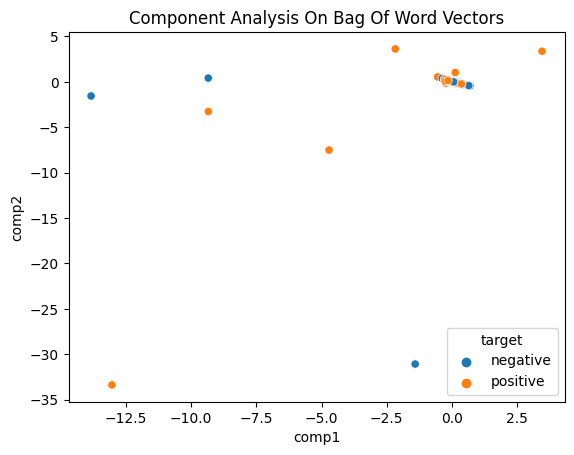

In [40]:
bow_tsne = TSNE(n_components=2, perplexity=10, n_iter=250, init="random")
bow_tsne.fit(bow_train_x.toarray())

tsne_bow_train_x = bow_tsne.fit_transform(bow_train_x.toarray())
bow_tsne_df = pd.DataFrame({"comp1" : tsne_bow_train_x[:, 0].tolist(),
                           "comp2" : tsne_bow_train_x[:, 1].tolist(),
                           "target" : train_y.flatten().tolist()})

bow_tsne_df['target'] = bow_tsne_df['target'].apply(lambda x : encoder.classes_[x])
sns.scatterplot(x="comp1", y="comp2", hue="target", data=bow_tsne_df)
plt.title("Component Analysis On Bag Of Word Vectors")

Text(0.5, 1.0, 'Component Analysis On TFIDF Vectors')

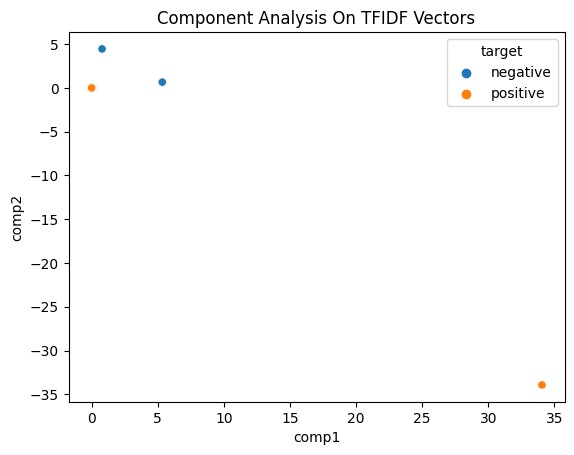

In [39]:
#### decomposed bag of words dataframe
tfidf_tsne = TSNE(n_components=2, perplexity=10, n_iter=250, init="random")
tfidf_tsne.fit(tfidf_train_x.toarray())

tsne_tfidf_train_x = tfidf_tsne.fit_transform(tfidf_train_x.toarray())
tfidf_tsne_df = pd.DataFrame({"comp1" : tsne_tfidf_train_x[:, 0].tolist(),
                           "comp2" : tsne_tfidf_train_x[:, 1].tolist(),
                           "target" : train_y.flatten().tolist()})

tfidf_tsne_df['target'] = tfidf_tsne_df['target'].apply(lambda x : encoder.classes_[x])
sns.scatterplot(x="comp1", y="comp2", hue="target", data=tfidf_tsne_df)
plt.title("Component Analysis On TFIDF Vectors")